# KNN Classification Analysis of Stroke Prediction 

In [1]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
install.packages("themis")
library(themis)

set.seed(2023)
options(repr.matrix.max.rows = 8) 

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction

"insert introduction"

## <br> Cleaning & Wrangling the Data

First, the data set was uploaded onto Google Drive and read into R using the URL link.


In [2]:
brainstroke_data <- read_csv("https://drive.google.com/uc?export=download&id=1yBiO_qBE9_YBvnEyPe2bazH5ZCOBb1d6")

Rows: 4981 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, ever_married, work_type, Residence_type, smoking_status
dbl (6): age, hypertension, heart_disease, avg_glucose_level, bmi, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### Table 1. Stroke Data Set Preview

In [3]:
brainstroke_data

gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Yes,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Yes,Private,Urban,83.75,29.1,never smoked,0


<br>The original data set contains variables such as marriage status (ever_married) that intuitively won't be useful in our analysis so it is taken out. Categorical variables that are in the "chr" format was changed to "fct" so that we can compute functions more easily later. The BMI variable was renamed so that it is more clear what the acronym stands for. 


In [4]:
brainstroke_data_v1 <- brainstroke_data |> 
    mutate(across(c(gender, hypertension:Residence_type, smoking_status:stroke),
                  as_factor)) |>
    select(1:4, 6:11)

colnames(brainstroke_data_v1)[8] <- 'body_mass_index'

##### Table 2. Cleaned Stroke Data Set 

In [5]:
brainstroke_data_v1

gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Private,Urban,171.23,34.4,smokes,1
Female,79,1,0,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Male,40,0,0,Private,Urban,191.15,31.1,smokes,0
Female,45,1,0,Govt_job,Rural,95.02,31.8,smokes,0
Male,40,0,0,Private,Rural,83.94,30.0,smokes,0
Female,80,1,0,Private,Urban,83.75,29.1,never smoked,0


<br> Next, we checked for missing data so that we can exclude those observations in our data analysis. Luckily, the data set does not include any missing data as shown in table 3. 

In [6]:
not_available <- brainstroke_data_v1 |>
    summarize(across(everything(), ~ sum(is.na(.))))

##### Table 3. Missing Data 

In [7]:
not_available

gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


<br> The first summary that was performed was calculating the proportions of the class labels in the stroke variable to check if the classes are balanced. As shown in table 4, 4733 observations did not get a stroke versus 248 observations that did get a stroke. The ratio of observations in stroke is about 1:20 which is extremely imbalanced. This is very likely to cause problems in KNN classification because the algorithm is based on majority vote. 

In [8]:
total_obs <- nrow(brainstroke_data_v1)

stroke_proportions <- brainstroke_data_v1 |>
    group_by(stroke) |>
    summarize(stroke_count = n(),
              percentage = round((stroke_count / total_obs) * 100, 2))

##### Table 4. Proportion of Observations +/- Stroke 

In [9]:
stroke_proportions

stroke,stroke_count,percentage
<fct>,<int>,<dbl>
0,4733,95.02
1,248,4.98


## <br> Selecting Predictor Variables 

The training data will be used to train our classifier and the testing data will be used to evaluate the accuracy of our classifier.  We chose to do a 75% to 25% training data to testing data split because we wanted to use more data to train for a more accurate model. The strata argument is set to the stroke variable so that there is an equal proportion of observations in each class that is assigned to each data set, so that there is a good representation of the original data set. Lastly, the analysis will be done with randomness via seeds (set at the top of the report) so that the data is still reproducible. 


In [10]:
brainstroke_split <- initial_split(brainstroke_data_v1, prop = 0.75, strata = stroke)

brainstroke_training <- training(brainstroke_split)
brainstroke_testing <- testing(brainstroke_split)

<br> To see if there was a pattern in the numerical variables for observations in each category of the stroke variable, the average BMI, glucose level, and age of those with or without stroke was computed. As shown in the table below, there are differences between the mean values of all three variables, notably  glucose level and age. This is expected as these two have been recognized as risk factors for stroke in numerous studies (___). 

In [11]:
stroke_bmi_gluc_age_avg <- brainstroke_training |>
    group_by(stroke) |>
    summarise(avg_bmi = round(mean(body_mass_index), 2),
              avg_glucose = round(mean(avg_glucose_level), 2),
              avg_age = round(mean(age), 2))

##### Table 5. Average BMI, Glucose Level, and Age Separated by Stroke Condition 

In [12]:
stroke_bmi_gluc_age_avg

stroke,avg_bmi,avg_glucose,avg_age
<fct>,<dbl>,<dbl>,<dbl>
0,28.46,104.9,42.62
1,30.34,129.3,67.35


<br> To confirm whether these 3 numerical variables will likely be useful for the classification, we compared how it interacts with the stroke condition in several visualizations. The first histogram shows the distribution of age distinguished in colour by the stroke condition. It shows that people who have had a stroke tend to be older whereas people who don’t have a stroke are of all ages. As we do see a trend in the stroke condition, this predictor variable will likely be useful in the classification.


In [13]:
histogram_data <- brainstroke_training |>
    mutate(stroke = recode(stroke, '0' = "No", '1' = "Yes"))
    
age_histogram_plot <- histogram_data |>
    ggplot(aes(x = age, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Age of Individual (Years)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Age") +
    theme(text = element_text(size=15))

##### Figure 1. Histogram of Population Age across Stroke Condition

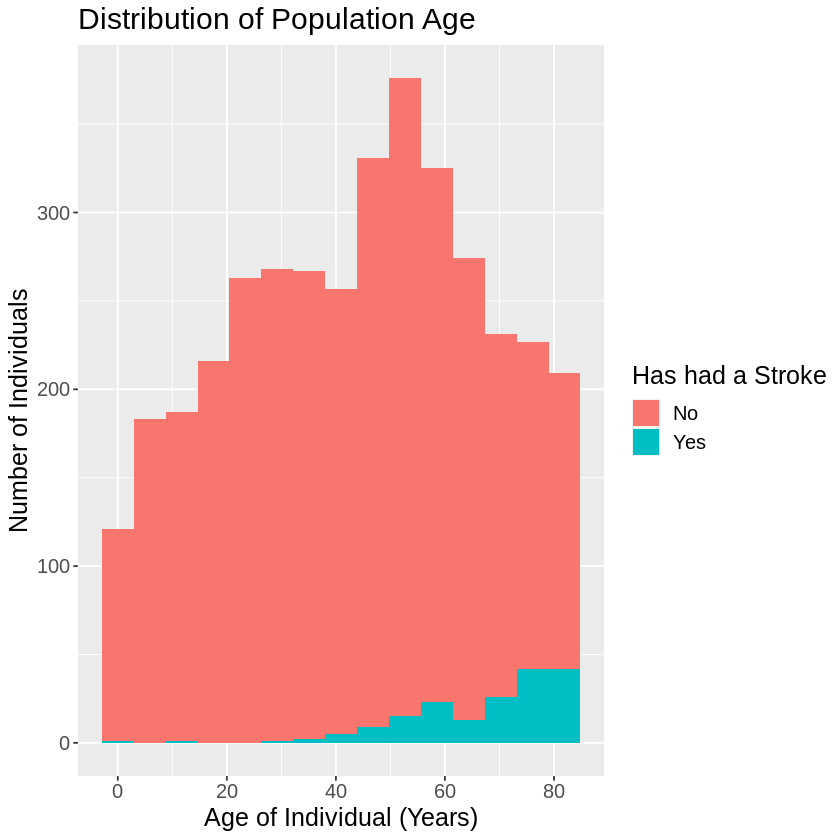

In [14]:
age_histogram_plot

<br>Next, we compared the distribution of BMI. There is no prominent observation of how BMI may affect the chances of getting a stroke as most of the observations that have had a stroke are across most BMI values. Thus, BMI will not be used as a predictor variable. 


In [15]:
bmi_histogram_plot <- histogram_data |>
    ggplot(aes(x = body_mass_index, fill = stroke)) +
    geom_histogram(bins = 25) +
    xlab("BMI of Individual (kg/m^2)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population BMI") +
    theme(text = element_text(size=15))

##### Figure 2. Histogram of Body Mass Index (BMI) across Stroke Condition

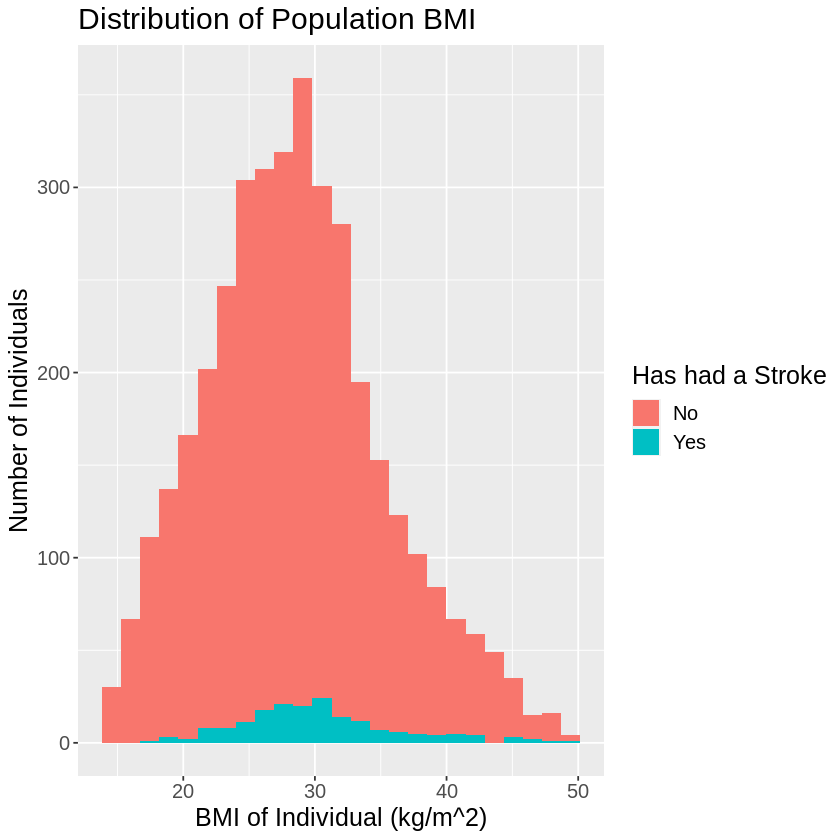

In [16]:
bmi_histogram_plot

<br>Finally, we compared the distribution of glucose levels. The values for the observations in the class label of people who have had a stroke gather outside of the safe zone of 120-180 (reference), at very low or very high glucose levels. However, we see this trend in the no-stroke condition as well. After checking the summarized data, the observations that got a stroke have a much higher average glucose level compared to the observations that did not get a stroke. In addition to previous studies that have indicated high glucose levels as a risk factor for stroke, this predictor variable may still be useful in the classification. 

In [17]:
glucose_histogram_plot <- histogram_data |>
    ggplot(aes(x = avg_glucose_level, fill = stroke)) +
    geom_histogram(bins = 15) +
    xlab("Glucose Level (mg/dL)") +
    ylab("Number of Individuals") +
    labs(fill = "Has had a Stroke") +
    ggtitle("Distribution of Population Glucose Levels") +
    theme(text = element_text(size=15))

##### Figure 3. Histogram of Glucose Level across Stroke Condition

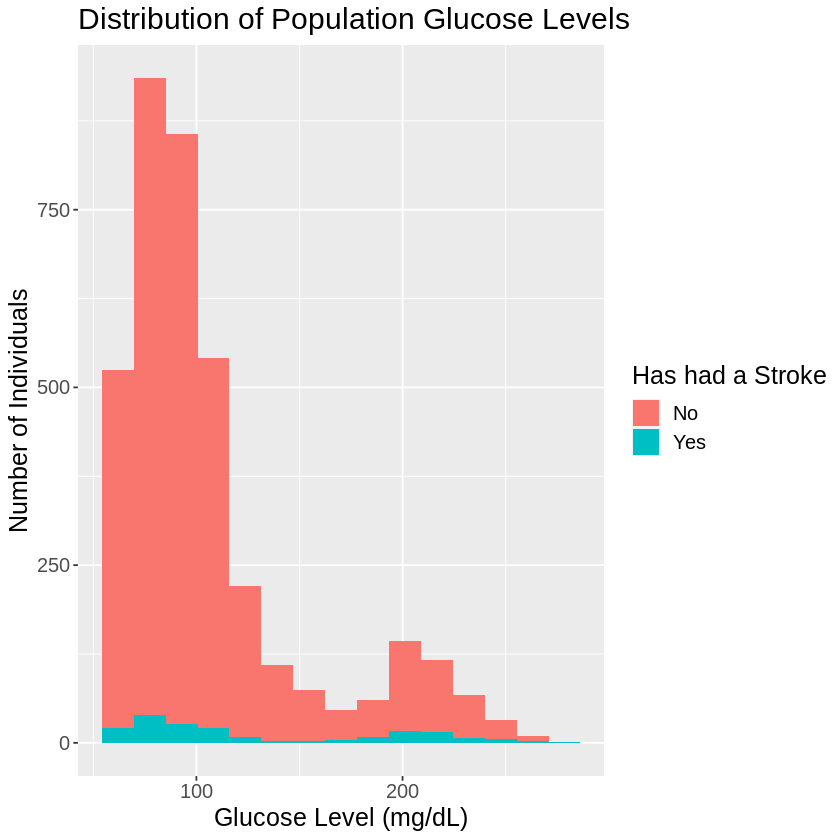

In [18]:
glucose_histogram_plot

##### Table 6. Average Glucose Level Separated by Stroke Condition 

In [19]:
select(stroke_bmi_gluc_age_avg, stroke, avg_glucose)

stroke,avg_glucose
<fct>,<dbl>
0,104.9
1,129.3


<br> Note: The categorical variables were not summarized because only the numerical variables were of interest since there is no distance to calculate between points with categorical variables. Thus, we can't use them in our classification algorithm explained below. 


## <br> Data Analysis
Classification will be performed using the K-nearest-neighbor (KNN) algorithm. The target variable is the “stroke” column. As determined with the summary statistics and visualizations above, the predictor variables are <b> age and glucose levels. 

To resolve the problem of class imbalance, we oversampled the rare class, which is the group that got a stroke. During this process, the preprocessing steps (scaling and centering the data) for all the variables were also completed.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6907631,5,0.010600178,Preprocessor1_Model01
1,roc_auc,binary,0.6553972,5,0.020098910,Preprocessor1_Model01
6,accuracy,binary,0.7140562,5,0.006754739,Preprocessor1_Model02
6,roc_auc,binary,0.7732888,5,0.015812075,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
46,accuracy,binary,0.7327979,5,0.005829061,Preprocessor1_Model10
46,roc_auc,binary,0.8105499,5,0.015351839,Preprocessor1_Model10
51,accuracy,binary,0.7319946,5,0.005732962,Preprocessor1_Model11
51,roc_auc,binary,0.8133943,5,0.015040678,Preprocessor1_Model11


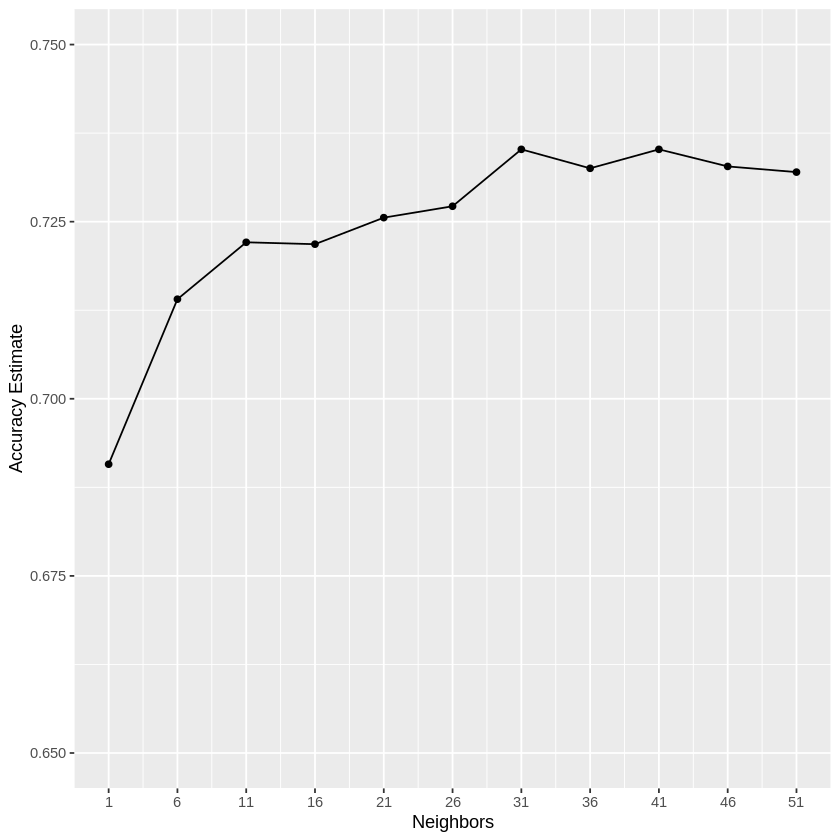

In [31]:
#input code for upsample which should be part of the recipe code

brainstroke_recipe_balanced <- 
    recipe(stroke ~ age + avg_glucose_level, data = brainstroke_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) |>
    step_rose(stroke, seed = 1234)


brainstroke_vfold <- vfold_cv(brainstroke_training, v = 5, strata = stroke)


knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

gridvals = tibble(neighbors = seq(1, 51, by = 5))

knn_results <- workflow() |>
       add_recipe(brainstroke_recipe_balanced) |>
       add_model(knn_tune) |>
       tune_grid(resamples = brainstroke_vfold, grid = gridvals) |>
       collect_metrics()
knn_results

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(1, 51, by = 5)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.65, 0.75)) # adjusting the y-axis
accuracy_versus_k

In [32]:
knn_spec_accurate <- nearest_neighbor(weight_func = "rectangular", neighbors = 31) |>
       set_engine("kknn") |>
       set_mode("classification")

brainstroke_fit <- workflow() |>
       add_recipe(brainstroke_recipe_balanced) |>
       add_model(knn_spec_accurate) |>
       fit(data = brainstroke_training)

brainstroke_test_predictions <- predict(brainstroke_fit, brainstroke_testing) |>
       bind_cols(brainstroke_testing)
brainstroke_test_predictions

brainstroke_prediction_accuracy <- brainstroke_test_predictions |>
         metrics(truth = stroke, estimate = .pred_class)             
brainstroke_prediction_accuracy

.pred_class,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,body_mass_index,smoking_status,stroke
<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,Male,67,0,1,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,81,0,0,Private,Urban,186.21,29.0,formerly smoked,1
1,Female,61,0,1,Govt_job,Rural,120.46,36.8,smokes,1
0,Female,54,0,0,Private,Urban,104.51,27.3,smokes,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,Male,59.00,1,0,Govt_job,Rural,253.93,32.1,formerly smoked,0
0,Male,3.00,0,0,children,Rural,194.75,20.1,Unknown,0
0,Male,1.32,0,0,children,Rural,107.02,18.8,Unknown,0
0,Male,41.00,0,0,Private,Rural,70.15,29.8,formerly smoked,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7592295
kap,binary,0.2101059


<br> As shown, the classes are now more balanced. However, there may be the issue of overfitting the model to the data because it increases the number of observations in the class that does have a stroke. Thus, cross-validation may not work as well and this should be noted for future research to use a more balanced dataset. 

In [34]:
#code for balanced data confirmation 

<br> To tune our model, cross-validation was performed to choose the best K value. We chose to do a __ fold split in consideration of the computation time. We chose to standardize the data because we’re using multiple numerical variables and they may be on different scales which will affect how the KNN algorithm calculates the nearest distance.  

In [31]:
#cross-validation code 

Then, a scatter plot was made to pick a K value that has a high accuracy estimate but also does not change its accuracy by much when we increase or decrease K to a nearby value. The K that fits this criterion is K= ____ with an accuracy of ___. 

In [32]:
#cross-validation plot

<br> After determining that K=__ will likely give us the most accurate results, we retrained the model with this K value to build our classifier. 


In [36]:
#rebuild model with best K

<br> Finally, we tested the classifier on data it has not seen before (ie. the testing data) to determine its accuracy.
With the metrics function, the calculated prediction accuracy was found to be ___. Compared to the estimated accuracy result in cross-validation (___), the prediction accuracy on testing data is better/worse. This indicates that the model is good/bad at generalizing to new data. Compared to the majority classifier calculated in the exploratory data analysis section (___%), it is higher/lower. This indicates that the method chosen is/isn’t extracting useful information from the predictor variables. 


In [37]:
#code for testing on testing data 

<br> The confusion matrix was also computed to see the predictions. In the context of stroke prediction, it is important that false negatives are prevented whereas false positives are not as big of a problem. As shown, our classifier has ___ false negatives, ___ false positives. (explain if results are good/bad)


In [38]:
#code for confusion matrix

<br> To model the classifier's accuracy, the result was visualized with a scatter plot using the predictor variables. Training data was coloured by stroke condition and the diagnosis of a random observation from the testing data was labelled in a different colour so that we can see where the classifier was making its choice. Accuracy was visualized by colouring the area where the classifier makes the classification. The classifier would be most accurate when the real class of the data point matches the colour of the plot background
 

In [39]:
#code for scatter plot

<br> To assess the classifier's predictive capacity, a mosaic plot of the confusion matrix was made. Cases where the truth matches the prediction indicate accurate predictions. From the plot, there are __ true positives, and __ true negatives. Cases where the truth does not match the prediction indicate false positives (__), and false negatives (___). 

In [40]:
#I can put the code for this if you guys don't know how to do it (Tiff)

## <br> Discussion 

## <br> References